In [109]:
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import iv as Iv #Modified Bessel function of the first kind of real order.
import scipy.special as sc

from scipy.stats import rice

from scipy.stats.mstats import gmean
from multiprocessing import cpu_count

from pathos.pools import ProcessPool as Pool

from utilities import Mask, Bp2f
import copy 

import seaborn as sea
import pandas as pd
from astropy.table import Table

%config Completer.use_jedi = False
%matplotlib inline

In [ ]:
sea.set_style("white")
sea.set_context("talk")
sea.set_style("ticks")

In [ ]:
nside = 32; names = ['SPASS only', 'CBASS only', 'both']

In [ ]:
total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_000.npy'%nside)#/1000 ## from uK to mK
total_sigma = np.load('/global/cscratch1/sd/jianyao/CBASS/Noise/homo_noise/5_fre_sigma_P_%s_uK_RJ.npy'%nside)#/1000 ## from uK to mK
P_nu0 = np.load('/global/cscratch1/sd/jianyao/CBASS/Foreground/P_11.99_s0_32_uK_RJ.npy')#/1000

mask_both = np.load('/global/cscratch1/sd/jianyao/CBASS/mask_both_%s.npy'%nside)
mask_index = np.load('/global/cscratch1/sd/jianyao/CBASS/masked_index.npy')

# for one noise realization

In [ ]:
As_betas_both = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_CBASS_001.npy')
As_betas_S = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_SPASS_only_001.npy')
As_betas_C = np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_32_with_CBASS_only_001.npy')

In [ ]:
sn_both = gmean(total_P/total_sigma, axis = 0)
sn_C = gmean((total_P/total_sigma)[1:5], axis = 0)
sn_S = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])

In [ ]:
betas_both = Bp2f(As_betas_both, mask_index, nside = nside)[2]
sig_B_both = Bp2f(As_betas_both, mask_index, nside = nside)[3]

betas_C = Bp2f(As_betas_C, mask_index, nside = nside)[2]
sig_B_C = Bp2f(As_betas_C, mask_index, nside = nside)[3]
betas_S = Bp2f(As_betas_S, mask_index, nside = nside)[2]
sig_B_S = Bp2f(As_betas_S, mask_index, nside = nside)[3]

In [ ]:
## sns for one realization; Sns averaged for all realizations
sns = np.array([sn_S[mask_index], sn_C[mask_index], sn_both[mask_index]]);
betas = np.array([betas_S[mask_index], betas_C[mask_index], betas_both[mask_index]])

betas_full = np.array([betas_S, betas_C, betas_both])
mc_error = np.array([sig_B_S, sig_B_C, sig_B_both])

bin_num = 60
SN_bins = np.linspace(np.log10(sns.min()), np.log10(sns.max()), bin_num + 1)
betas_bins = np.linspace(betas.min(),betas.max(), bin_num + 1)

for realization 1


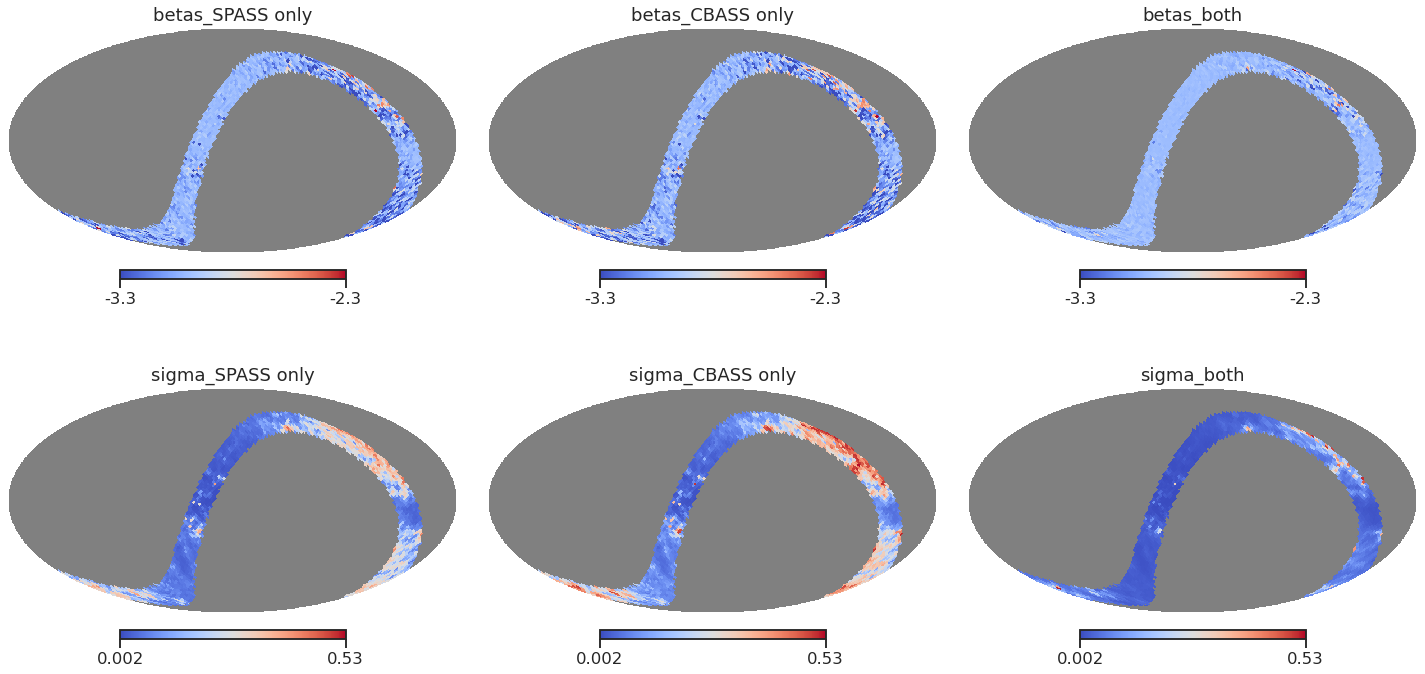

In [14]:
plot_sky_betas(betas_full, mc_error, names, title = 'for realization 1')
plt.savefig('figures/Dyne_betas_sampling_errors_1_realization.pdf', format = 'pdf')

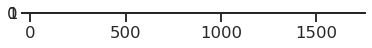

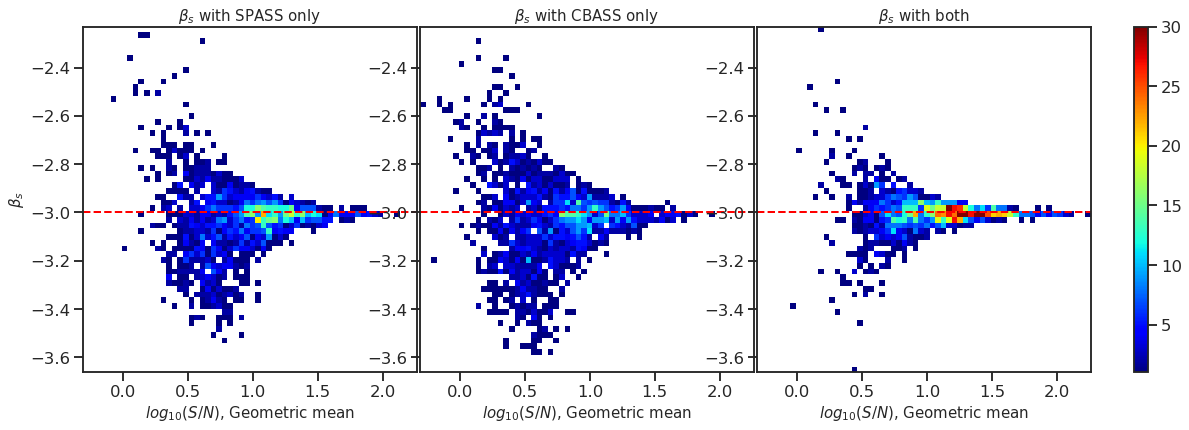

In [26]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
my_cmap = copy.copy(plt.cm.get_cmap("jet"))
my_cmap.set_under('w',0)

for i in range(3):

    x0, y0 = sns[i], betas[i]
    counts, xedges, yedges, im  = ax[i].hist2d(np.log10(x0),y0, bins = [SN_bins, betas_bins], cmap = my_cmap, cmin = 1, vmax = 30)
    ax[i].set_title(r'$\beta_s$ with %s'%(names[i]), fontsize = 15)
    ax[i].axhline(-3.0, c = 'red', lw = 2, ls = '--')
    
    ax[i].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
    if i ==0:
        ax[i].set_ylabel(r'$\beta_s$', fontsize = 15)
    
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.01, hspace=0.02)    
cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)    

# plt.savefig('figures/Dyne_2d_dist_1_realization.pdf', format = 'pdf')

In [65]:
sea.set_style("darkgrid")
# sea.set_context("talk")
sea.set_style("ticks")

In [231]:
data_names = np.empty(1755*3, dtype = 'object')

In [232]:
data_names[1755*0:1755*1] = 'spass';
data_names[1755*1:1755*2] = 'cbass';
data_names[1755*2:1755*3] = 'both';

In [233]:
data_names

array(['spass', 'spass', 'spass', ..., 'both', 'both', 'both'],
      dtype=object)

In [203]:
t = Table((np.log10(sns.flatten()),betas.flatten(),data_names),names = ('SNR','beta_s','data'))
df = pd.DataFrame(np.array(t))

In [206]:
df.astype({'data':"category"})

,SNR,beta_s,data
0,1.012974,-2.916790,spass
1,0.839599,-3.204992,spass
2,1.009634,-3.022025,spass
3,1.033919,-2.918782,spass
4,0.798214,-2.922606,spass
...,...,...,...
5260,0.896244,-2.956282,both
5261,1.260427,-2.968130,both
5262,1.152422,-2.996152,both
5263,1.218378,-2.997247,both


<Figure size 1440x504 with 0 Axes>

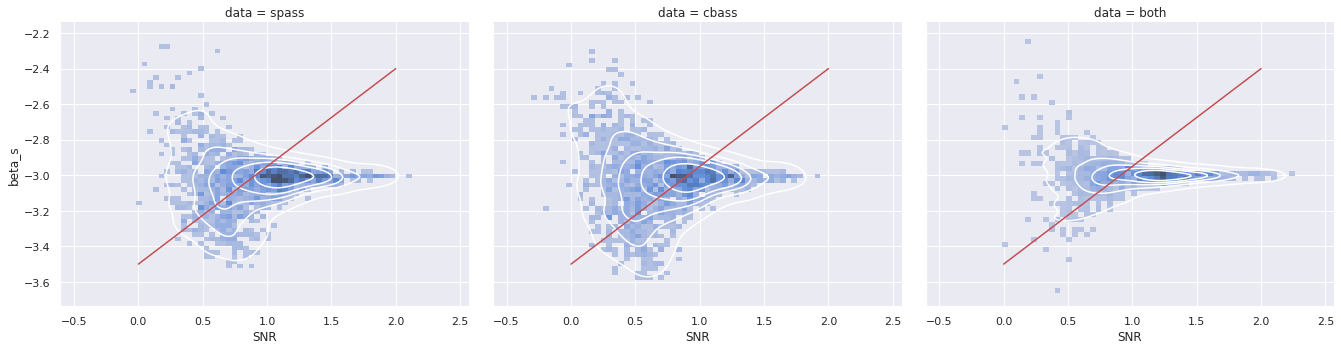

In [237]:
plt.figure(figsize = (20, 7))
g = sea.FacetGrid(df, col = 'data')
g.map(sea.histplot, 'SNR', 'beta_s', bins = 50)
g.map(sea.kdeplot, 'SNR', 'beta_s', levels=6, color = 'white')

axes = g.fig.axes
x = [0,2]
y = [-3.5,-2.4]
for ax in axes:
    ax.plot(x, y, c = 'r')  

g.fig.set_size_inches(20,6)
# g.savefig('test.pdf', format = 'pdf')

/global/homes/j/jianyao/my3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:1668: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


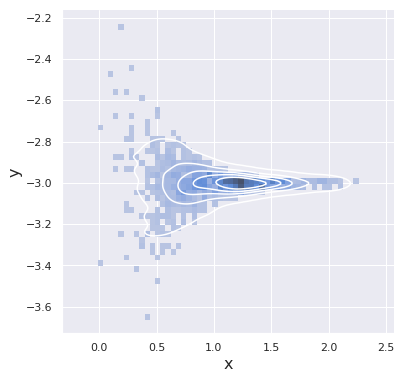

In [99]:
g = sea.JointGrid(x = np.log10(x0), y = y0, ratio=100)
g.plot_joint(sea.histplot, bins = 50)
g.plot_joint(sea.kdeplot,levels=6, color = 'white')
# g.plot_marginals(sea.histplot, kde=True)
g.set_axis_labels('x', 'y', fontsize=16)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()

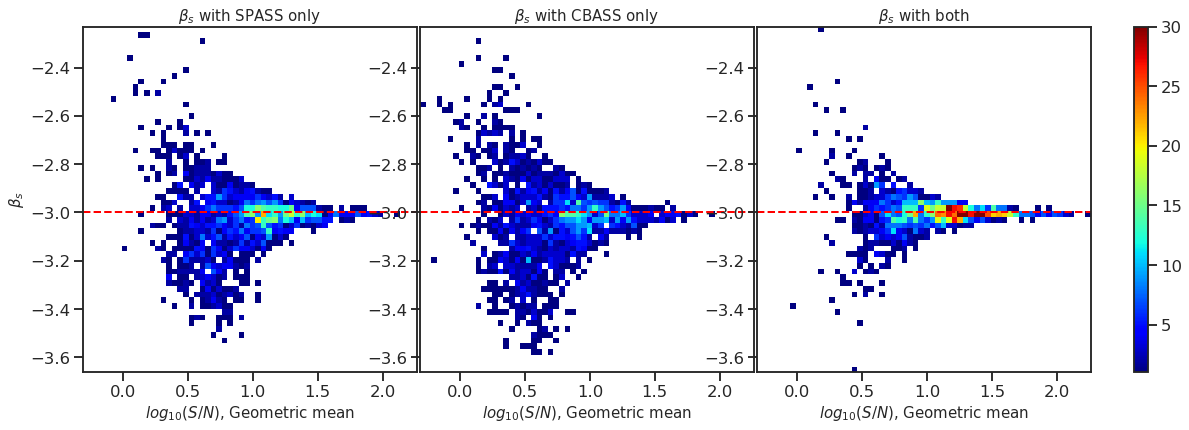

In [205]:
plot_2d(betas, sns, betas_bins, SN_bins, names)

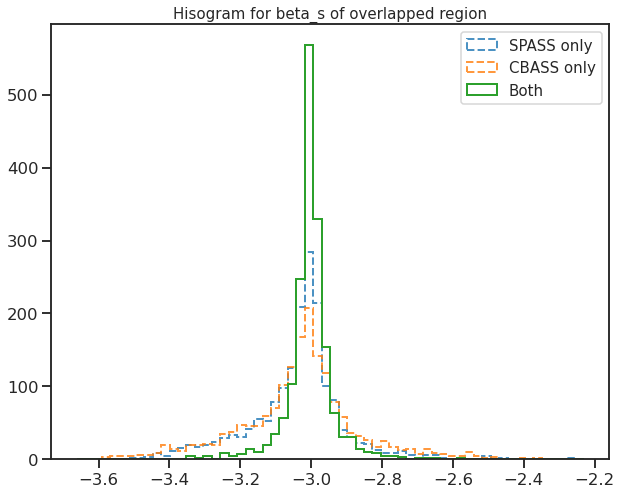

In [165]:
plt.figure(figsize = (10,8))
plt.hist(betas_S[mask_index],  bins = betas_bins, histtype="step", label = 'SPASS only', lw = 2, linestyle = '--',alpha = 0.8)

plt.hist(betas_C[mask_index], bins = betas_bins, histtype="step" , label = 'CBASS only', lw = 2, linestyle = '--',alpha = 0.8)

h = plt.hist(betas_both[mask_index],  bins = betas_bins, histtype="step" , label = 'Both', lw = 2)

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

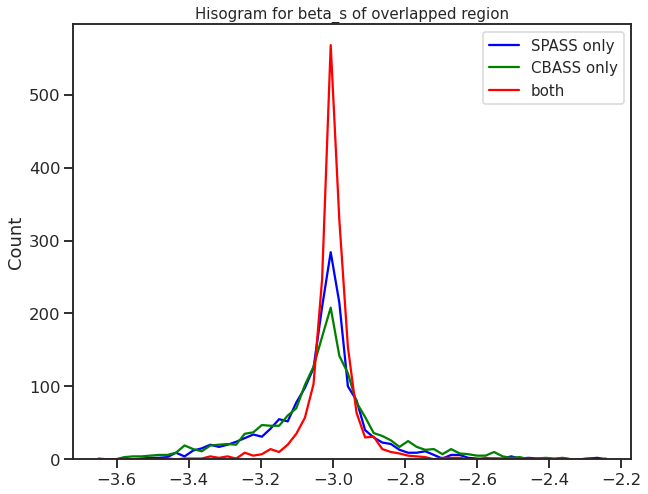

In [16]:
plt.figure(figsize = (10,8))

sea.histplot(betas[0], bins = betas_bins, fill=False, element="poly",label = 'SPASS only',color = 'blue')
sea.histplot(betas[1], bins = betas_bins, fill=False, element="poly",label = 'CBASS only',color = 'green')

sea.histplot(betas[2], bins = betas_bins, fill=False, element="poly",label = 'both',color = 'red')

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

plt.savefig('figures/Dyne_betas_1_realization.pdf', format = 'pdf')

# combine realizations

## beta_s maps

In [5]:
def combine(name,nside, N, mask_index):
    betas_all = np.zeros((N, 12*nside**2))
    for j in range(N):
        results= np.load('/global/cscratch1/sd/jianyao/CBASS/Results/s0_only_homo_noise/Dyne_As_betas_masked_both_%s_with_%s_%03d.npy'%(nside, name,j))
        betas_all[j] = Bp2f(results,mask_index, nside = nside)[2]
    
    mean = np.mean(betas_all, axis = 0)
    std = np.std(betas_all, axis = 0); std_masked = np.ma.masked_where(std>100, std)
    return mean, std_masked.filled(fill_value = hp.UNSEEN)

In [6]:
beta_both_mean = combine('SPASS_CBASS', 32, 50, mask_index)[0]
beta_both_std = combine('SPASS_CBASS', 32, 50, mask_index)[1]

beta_S_mean = combine('SPASS_only', 32, 50, mask_index)[0]
beta_S_std = combine('SPASS_only', 32, 50, mask_index)[1]

beta_C_mean = combine('CBASS_only', 32, 50, mask_index)[0]
beta_C_std = combine('CBASS_only', 32, 50, mask_index)[1]

In [7]:
mean_betas_full = np.array([beta_S_mean, beta_C_mean, beta_both_mean])
mean_betas = np.array([beta_S_mean[mask_index], beta_C_mean[mask_index], beta_both_mean[mask_index]])
std_betas = np.array([beta_S_std, beta_C_std, beta_both_std])

In [8]:
def plot_sky_betas(betas, sigmas, cases, title):
    '''
    input: full-sky maps
    -------------
    betas, total set of recovered beta_s for each case. Shape(3, 12*nside**2);
    sigmas, total set of error of beta_s for each case. Shape(3, 12*nside**2);
    cases, names for each case.
    '''
    plt.figure(figsize = (20, 10))
    print(title)
    for i in range(len(betas)):
    
        hp.mollview(betas[i], cmap = 'coolwarm', sub = int('23%s'%(i+1)), title = 'betas_%s'%cases[i], min = -3.3, max = -2.3)
        hp.mollview(sigmas[i], cmap = 'coolwarm', sub = int('23%s'%(i+4)), title = 'sigma_%s'%cases[i], min = 0.002, max = 0.53)


#     hp.mollview(betas_C, cmap = 'coolwarm', sub = 232, title = 'betas_C', min = -3.3, max = -2.3)
#     hp.mollview(sig_B_C, cmap = 'coolwarm', sub = 235, title = 'sigma_CBASS', min = 0.002, max = 0.53)

#     hp.mollview(betas_both, cmap = 'coolwarm',sub = 233, title = 'beta_s_both', min = -3.3, max = -2.3)
#     hp.mollview(sig_B_both, cmap = 'coolwarm', sub = 236, title = 'sigma_both', min = 0.002, max = 0.53)

betas_for_50_realizations


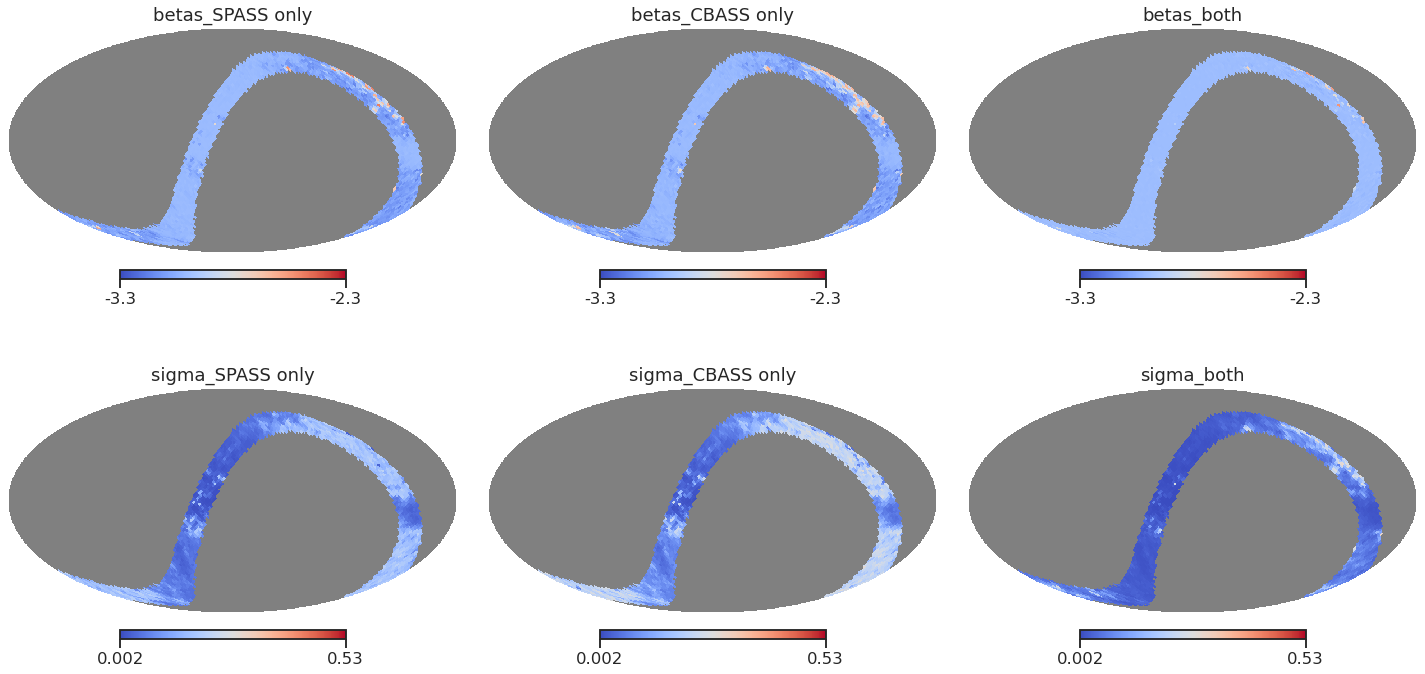

In [21]:
plot_sky_betas(mean_betas_full, std_betas, names, title = 'betas_for_50_realizations')
plt.savefig('figures/Dyne_betas_noise_errors_50_realization.pdf', format = 'pdf')

In [272]:
exceed_index[0].shape

(39,)

In [63]:
def one_sigma(betas, std, n):

    exceed_index = np.where(abs(betas +3) > n*std[mask_index]) ## index of the mask_index (within the overlapped region)
    print(exceed_index[0].shape)
    one_sig = np.zeros(12*nside**2)
    index = np.arange(12*nside**2)

    one_sig[np.delete(index, mask_index)] = hp.UNSEEN
    one_sig[mask_index[exceed_index]] = 1
    
    return one_sig, exceed_index


$-3 \pm 1 \sigma$

(52,)
(68,)
(10,)


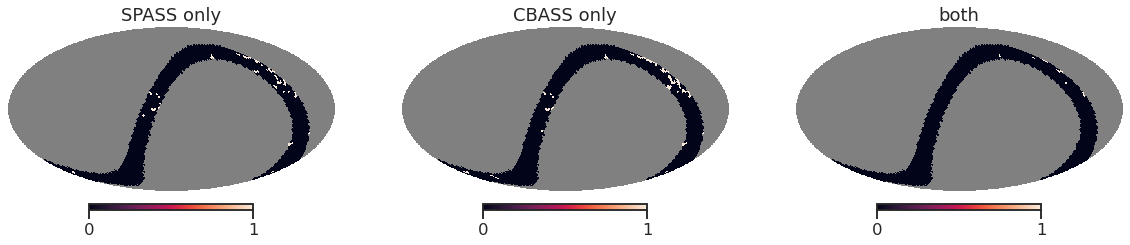

In [13]:
fig, ax = plt.subplots(1,3,figsize = (20, 4.5))

for i in range(len(ax)):
    plt.sca(ax[i])
    hp.mollview(one_sigma(mean_betas[i], std_betas[i], 1)[0], title = names[i],fig = fig.number, hold=True)
# hp.mollview(one_sigma(mean_betas[1], std_betas[1]), sub = 132, title = 'CBASS', xsize=width)
# hp.mollview(one_sigma(mean_betas[2], std_betas[2]), sub = 133, title = 'both', xsize=width)

# plt.savefig('figures/Dyne_betas_beyond_1sigma_50_realization.pdf', format = 'pdf')

(19,)
(30,)
(4,)


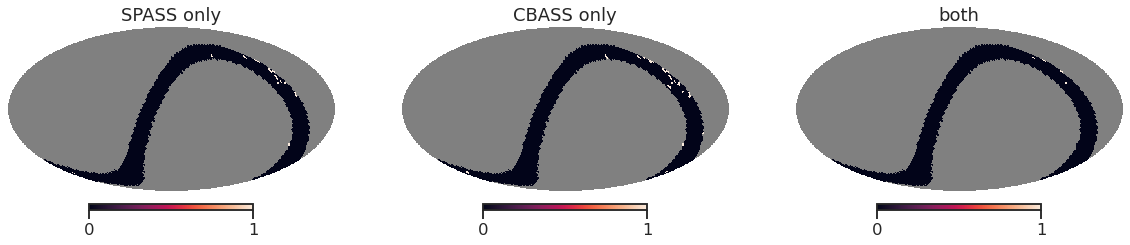

In [67]:
fig, ax = plt.subplots(1,3,figsize = (20, 4.5))

for i in range(len(ax)):
    plt.sca(ax[i])
    hp.mollview(one_sigma(mean_betas[i], std_betas[i], 2)[0], title = names[i],fig = fig.number, hold=True)

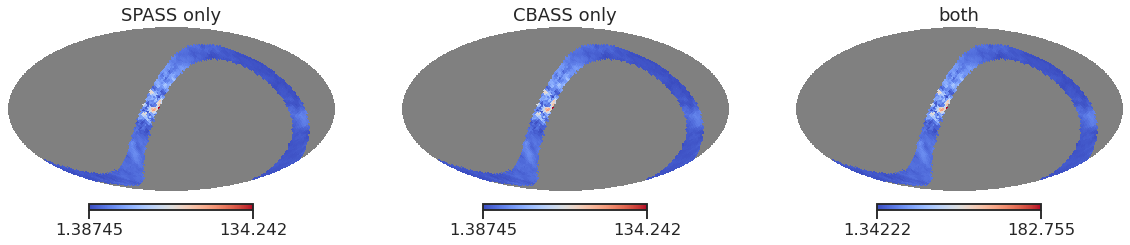

In [70]:
fig, ax = plt.subplots(1,3,figsize = (20, 4.5))
## SNR for each case
for i in range(len(ax)):
    plt.sca(ax[i])
    hp.mollview(Mask(SNS[i], mask_both), title = names[i],fig = fig.number, hold=True, cmap = 'coolwarm')

### test 

0.0 180.0 -180.0 180.0


Text(0.9081388897559997, 0.6277627143172103, 'TF0.1')

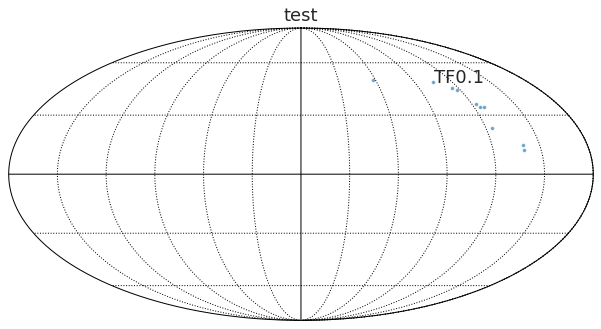

In [290]:
# hp.gnomview(title="Galactic map of Test Fields", rot = [-37, 27])
hp.mollview(title='test')
hp.graticule()

theta, phi = hp.pix2ang(nside = nside, ipix = mask_index[exceed_index])

hp.projscatter(theta, phi, coord='G', s = 5, alpha = 0.5)

lab = ['TF0.1', 'TF0.2', 'TF0.3', 'TF0.4', 'TF0.5', 'TF0.6' ]


# hp.projtext(theta[0],phi[0], 'TF0.1', coord='G')

hp.projtext(255, 48, 'TF0.1', coord='G', lonlat = True)

0.0 180.0 -180.0 180.0


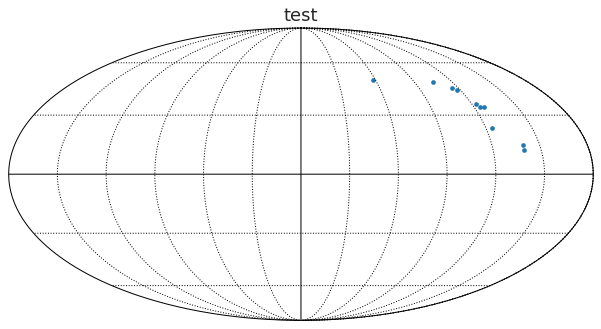

In [297]:
# hp.gnomview(title="Galactic map of Test Fields", rot = [-37, 27])
hp.mollview(title='test')
hp.graticule()

theta, phi = hp.pix2ang(nside = nside, ipix = mask_index[exceed_index])

# hp.projscatter(theta, phi, coord='G', s = 5, alpha = 0.5)
ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)

hp.projscatter(ra, dec, coord = 'G', lonlat = True, s = 10)
# hp.projtext(theta[0],phi[0], 'TF0.1', coord='G')

# hp.projtext(phi, theta, coord='G', lonlat = True)

In [270]:
SnS[2][exceed_index]

array([1.89643349, 1.64827506, 1.39108522, 1.7342369 , 1.9381537 ,
       1.34221527, 1.7325329 , 1.35186908, 1.70629332, 1.77178925])

41.105504123373855 138.89449587662614 -48.89449587662614 48.89449587662614


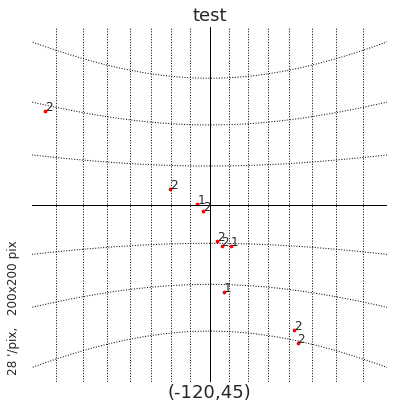

In [284]:
hp.gnomview(title='test', rot = [-120,45], reso = 28)
hp.graticule()

theta, phi = hp.pix2ang(nside = nside, ipix = mask_index[exceed_index])

ra = np.rad2deg(phi)
dec = np.rad2deg(0.5 * np.pi - theta)

hp.projscatter(ra, dec, coord='G', s = 5, lonlat = True, color = 'red')
for i in range(len(ra)):
    hp.projtext(ra[i], dec[i],  '%.0f'%SnS[2][exceed_index][i], coord='G', lonlat = True, fontsize = 12)

In [288]:
ra

array([301.66666667, 255.53571429, 244.5       , 242.41935484,
       237.65625   , 233.4375    , 236.25      , 236.25      ,
       220.78125   , 220.78125   ])

In [249]:
dec

array([49.70239033, 48.14120779, 44.99388015, 43.40685849, 35.68533471,
       34.22886633, 34.22886633, 23.31795707, 14.47751219, 12.02469918])

In [234]:
np.degrees(theta)

array([40.29760967, 41.85879221, 45.00611985, 46.59314151, 54.31466529,
       55.77113367, 55.77113367, 66.68204293, 75.52248781, 77.97530082])

In [237]:
phi

array([5.26507658, 4.45993957, 4.26733002, 4.23101591, 4.14788405,
       4.07425297, 4.12334036, 4.12334036, 3.85335974, 3.85335974])

In [235]:
np.degrees(phi)

array([301.66666667, 255.53571429, 244.5       , 242.41935484,
       237.65625   , 233.4375    , 236.25      , 236.25      ,
       220.78125   , 220.78125   ])

In [163]:
print('%.1f'%SnS[0][exceed_index][i])

2.5


0.0 180.0 -180.0 180.0


(19,)


0.0 180.0 -180.0 180.0


(30,)


0.0 180.0 -180.0 180.0


(4,)


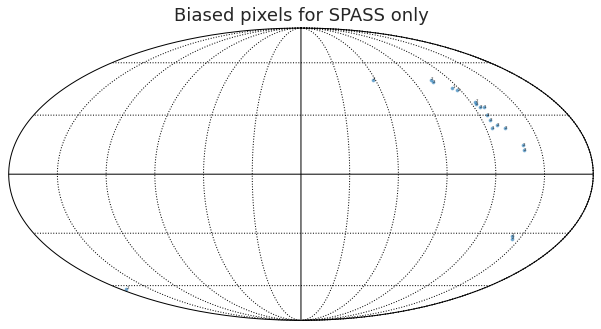

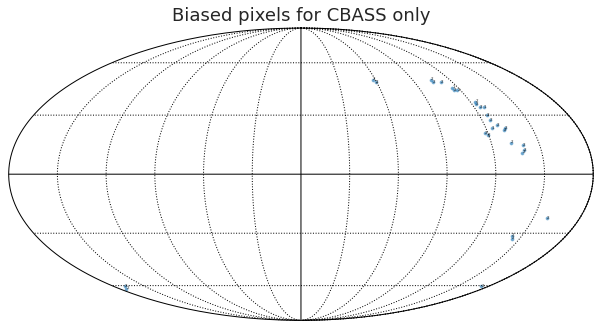

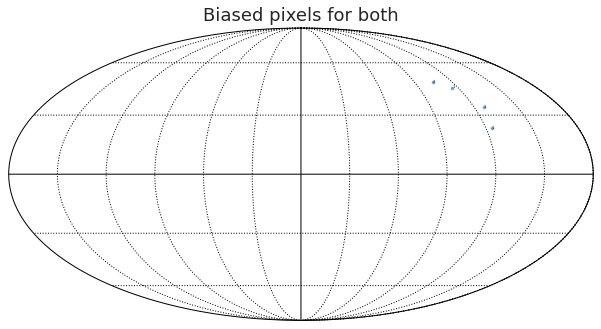

In [208]:
for j in range(3):
    
    exceed_index = one_sigma(mean_betas[j], std_betas[j], 2)[1]
    
    hp.mollview(title="Biased pixels for %s"%names[j])
    hp.graticule()

    theta, phi = hp.pix2ang(nside = nside, ipix = mask_index[exceed_index])

    hp.projscatter(theta, phi, coord='G', s = 5, alpha = 0.5)

    for i in range(len(exceed_index[0])):
        hp.projtext(theta[i], phi[i], '%.0f'%SnS[j][exceed_index][i], coord='G', fontsize = 4)

#     plt.savefig('figures/biased_pixels_%s.pdf'%names[j], format = 'pdf')

$-3\pm 2\sigma$

(52,)
(68,)
(10,)


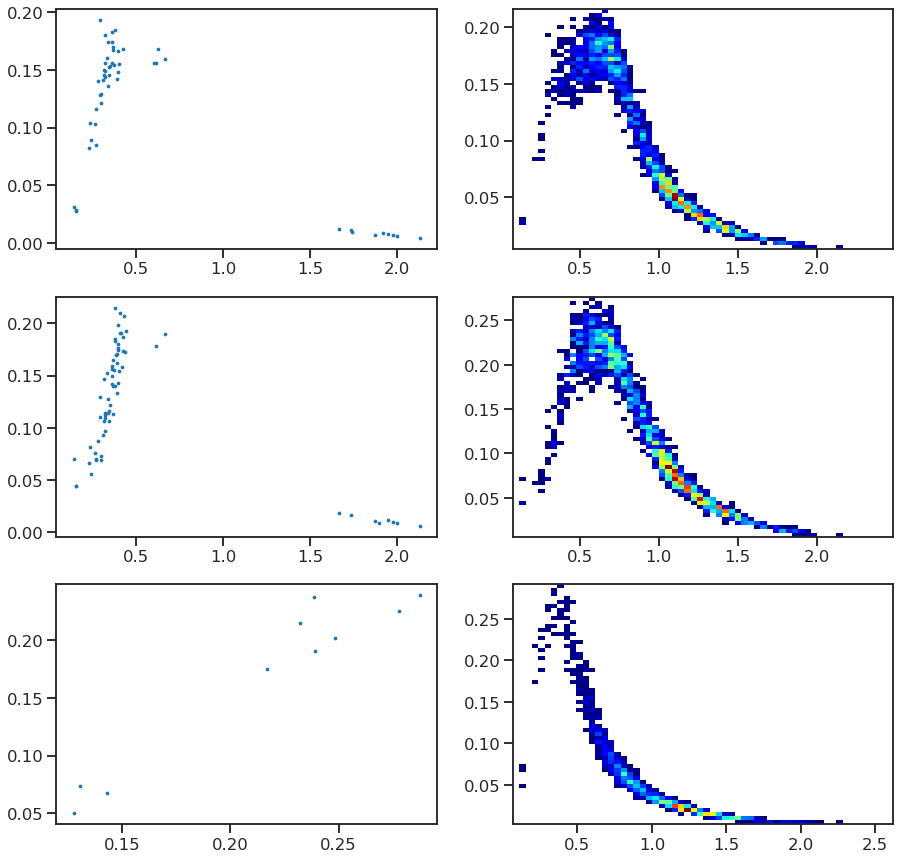

In [209]:
fig, ax = plt.subplots(3,2, figsize = (15,15))

bin_num = 60
SN_bins = np.linspace(np.log10(SNS.min()), np.log10(SNS.max()), bin_num + 1)
std_bins = np.linspace(std_betas[0][mask_index].min(), std_betas[0][mask_index].max(), bin_num + 1)
for i in range(3):
    
    exceed_index = one_sigma(mean_betas[i], std_betas[i], 1)[1]
    
    my_cmap = copy.copy(plt.cm.get_cmap("jet"))
    my_cmap.set_under('w',0)
    
    SN_bins = np.linspace(np.log10(SNS[i].min()), np.log10(SNS[i].max()), bin_num + 1)
    std_bins = np.linspace(std_betas[i][mask_index].min(), std_betas[i][mask_index].max(), bin_num + 1)

    ax[i][0].scatter(np.log10(SNS[i][mask_index[exceed_index]]), std_betas[i][mask_index[exceed_index]], 5*np.ones(len(exceed_index)))
    
    ax[i][1].hist2d(np.log10(SNS[i][mask_index]), std_betas[i][mask_index], bins = [SN_bins,std_bins],cmap = my_cmap, cmin = 1)

plt.savefig('figures/std_against_SNR.pdf', format = 'pdf')

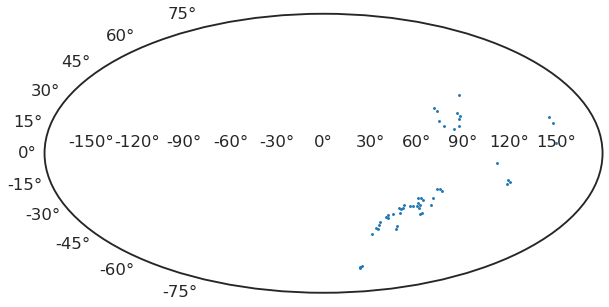

In [104]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='mollweide')

mask_index[exceed_index]

theta, phi = hp.pix2ang(nside = nside, ipix = mask_index[exceed_index])
ax.scatter(theta, phi, 2)

In [123]:
def IndexToDeclRa(NSIDE,index):
    theta,phi=hp.pix2ang(NSIDE,index)
    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    
    return ra, dec

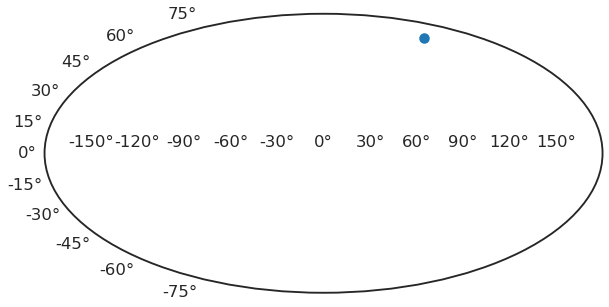

In [141]:
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='mollweide')
# theta, phi = hp.pix2ang(nside = nside, ipix = 100)
x, y = IndexToDeclRa(nside,500)
ax.scatter(np.radians(x),np.radians(y))

(52,)


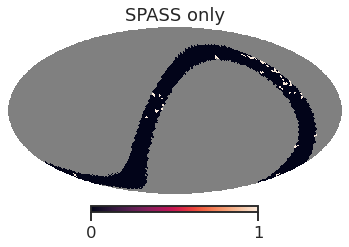

In [95]:
hp.mollview(one_sigma(mean_betas[0], std_betas[0], 1)[0], title = names[i],fig = fig.number, hold=True)

0.0 180.0 -180.0 180.0


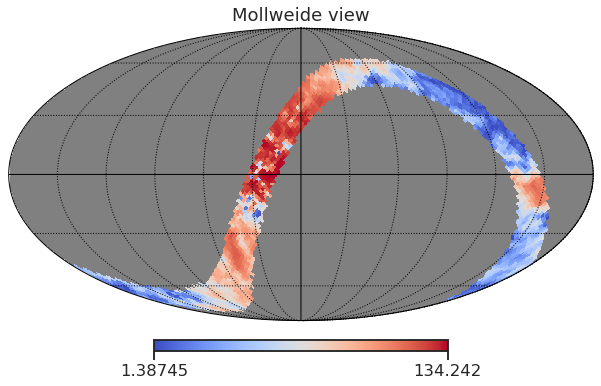

In [89]:
hp.mollview(Mask(SNS[0], mask_both), norm = 'hist', cmap = 'coolwarm')
hp.graticule(30)

In [31]:
def plot_2d(betas, sns, beta_bin, sn_bin, names):
    
    '''
    masked regions
    '''

    fig, ax = plt.subplots(1,3, figsize = (20,6))
    my_cmap = copy.copy(plt.cm.get_cmap("jet"))
    my_cmap.set_under('w',0)

    for i in range(3):

        x0, y0 = sns[i], betas[i]
        counts, xedges, yedges, im  = ax[i].hist2d(np.log10(x0),y0, bins = [sn_bin, beta_bin], cmap = my_cmap, cmin = 1, vmax = 30)
        ax[i].set_title(r'$\beta_s$ with %s'%(names[i]), fontsize = 15)
        ax[i].axhline(-3.0, c = 'red', lw = 2, ls = '--')

        ax[i].set_xlabel(r'$log_{10}(S/N)$, Geometric mean', fontsize = 15)
        if i ==0:
            ax[i].set_ylabel(r'$\beta_s$', fontsize = 15)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.01, hspace=0.02)    
    cb_ax = fig.add_axes([0.83, 0.1, 0.01, 0.8])
    cbar = fig.colorbar(im, cax=cb_ax)  

## average SN over different noise realizations

In [15]:
N = 50

SN_S = np.zeros((N, 12*nside**2)); 
SN_C = np.zeros((N, 12*nside**2));
SN_both = np.zeros((N, 12*nside**2))
for i in range(N):
    total_P = np.load('/global/cscratch1/sd/jianyao/CBASS/Observations/homo_noise/totalP_s0_%s_uK_RJ_%03d.npy'%(nside, i))

    SN_both[i] = gmean(total_P/total_sigma, axis = 0)
    SN_C[i] = gmean((total_P/total_sigma)[1:5], axis = 0)
    SN_S[i] = gmean([(total_P/total_sigma)[0],(total_P/total_sigma)[2],(total_P/total_sigma)[3],(total_P/total_sigma)[4]])
Sn_S = np.mean(SN_S, axis = 0)   
Sn_C = np.mean(SN_S, axis = 0) 
Sn_both = np.mean(SN_both, axis = 0) 

In [22]:
SnS = np.array([Sn_S[mask_index], Sn_C[mask_index], Sn_both[mask_index]]);

In [29]:
bin_num = 60
# SN_bins = np.linspace(np.log10(sns.min()), np.log10(sns.max()), bin_num + 1)

SN_bins = np.linspace(np.log10(SnS.min()), np.log10(SnS.max()), bin_num + 1)

mean_betas_bins = np.linspace(mean_betas.min(),mean_betas.max(), bin_num + 1)

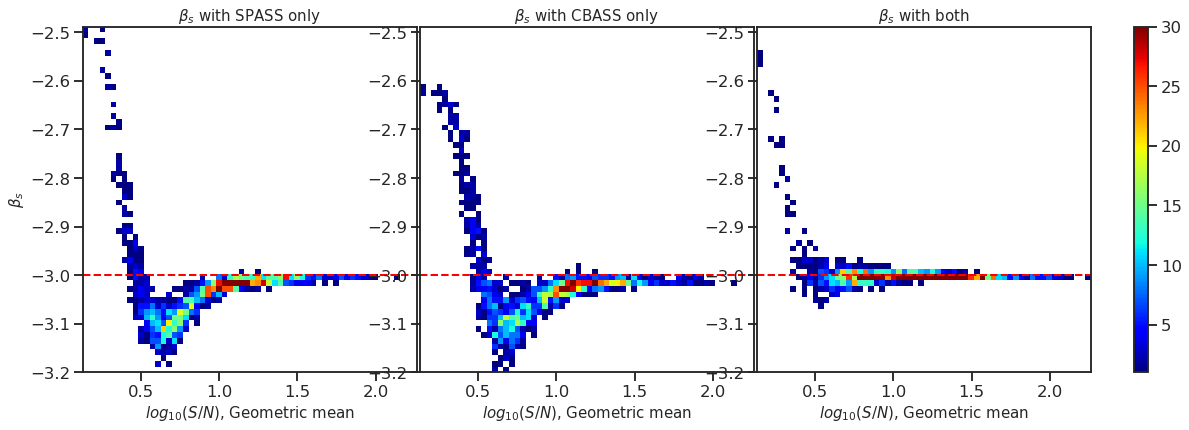

In [32]:
## SNR maps averaged for 50 noise realizations
plot_2d(mean_betas, SnS, mean_betas_bins, SN_bins, names = names)
plt.savefig('figures/Dyne_2d_50_realization.pdf', format = 'pdf')

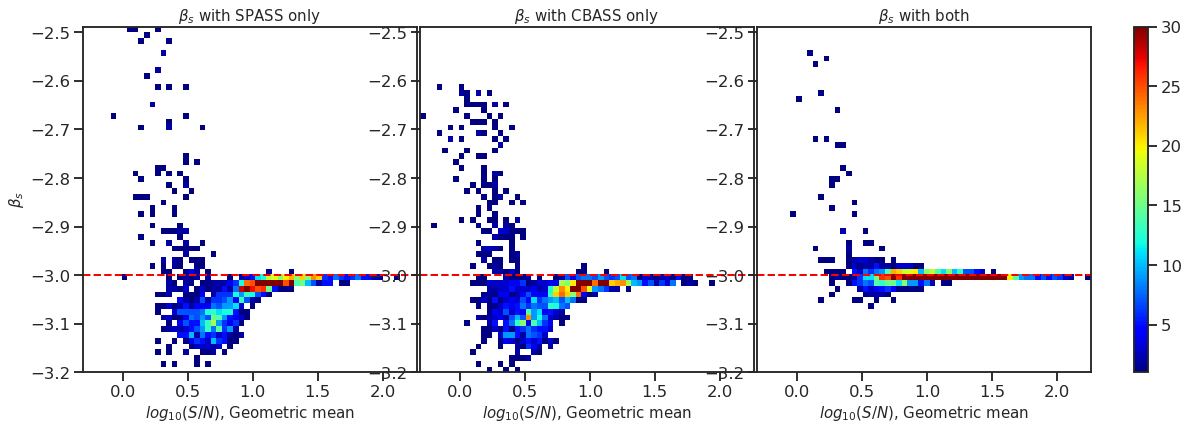

In [216]:
## SNR maps for noise realization seed 0
plot_2d(mean_betas, sns, mean_betas_bins, SN_bins, names = names)

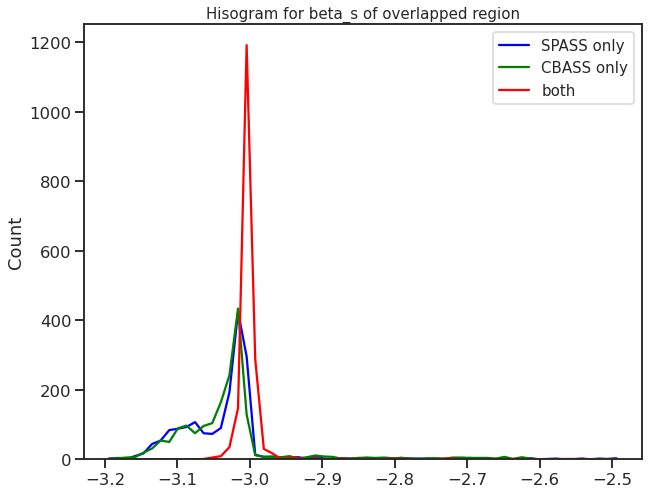

In [57]:
plt.figure(figsize = (10,8))

sea.histplot(mean_betas[0], bins = mean_betas_bins, fill=False, element="poly",label = 'SPASS only',color = 'blue')
sea.histplot(mean_betas[1], bins = mean_betas_bins, fill=False, element="poly",label = 'CBASS only',color = 'green')

sea.histplot(mean_betas[2], bins = mean_betas_bins, fill=False, element="poly",label = 'both',color = 'red')

plt.title('Hisogram for beta_s of overlapped region', fontsize = 15)
plt.legend(fontsize = 15)

plt.savefig('figures/Dyne_betas_1d_50_realization.pdf', format = 'pdf')

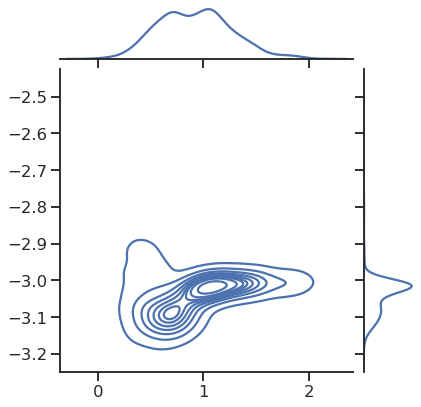

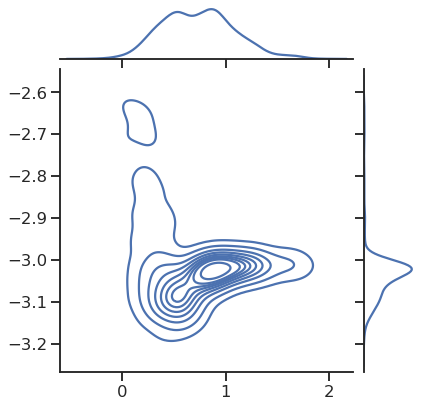

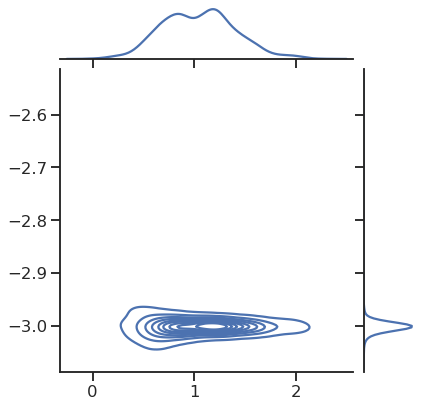

In [376]:
sea.jointplot(x = np.log10(sn_S[mask_index]), y=beta_S_mean[mask_index], kind = 'kde')
sea.jointplot(x = np.log10(sn_C[mask_index]), y=beta_C_mean[mask_index], kind = 'kde')
sea.jointplot(x = np.log10(sn_both[mask_index]), y=beta_both_mean[mask_index], kind = 'kde')

In [322]:
results = np.zeros((1755*3, 3),dtype = 'object')

for i in range(3):
    
    results[1755*i:1755*(i+1), 0] = names[i]
    results[1755*i:1755*(i+1), 1] = mean_betas[i]
    results[1755*i:1755*(i+1), 2] = np.log10(sns[i])

In [346]:
convert_dict = {'cases': str,
                'beta_s': float,
                'SNR': float
               }

In [353]:
results = pd.DataFrame(results, columns = ['cases', 'beta_s', 'SNR'])
results = results.astype(convert_dict)

In [354]:
print(results.dtypes)

cases      object
beta_s    float64
SNR       float64
dtype: object


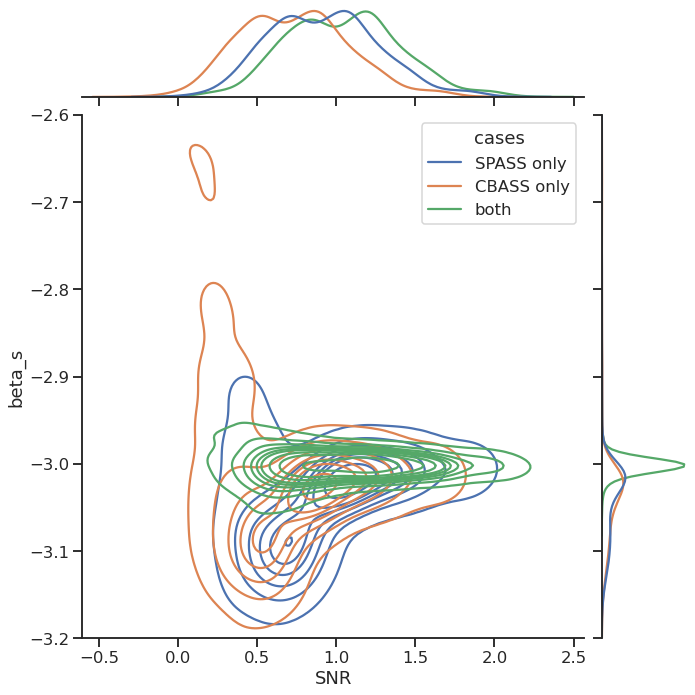

In [366]:
sea.jointplot(data=results, x="SNR", y="beta_s", hue="cases", kind="kde", height=10, ylim = [-3.2, -2.6])